In [1]:
import yfinance as yf
from datetime import datetime
import plotly.express as px
import pandas as pd
import torch
import torchsde
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
STOCK_NAME = "NESN.SW"

TIME_PERIOD = "1d"
TIME_INTERVAL = "1m"
DT = 5 * 60

LOCAL_WINDOW_SIZE = 10

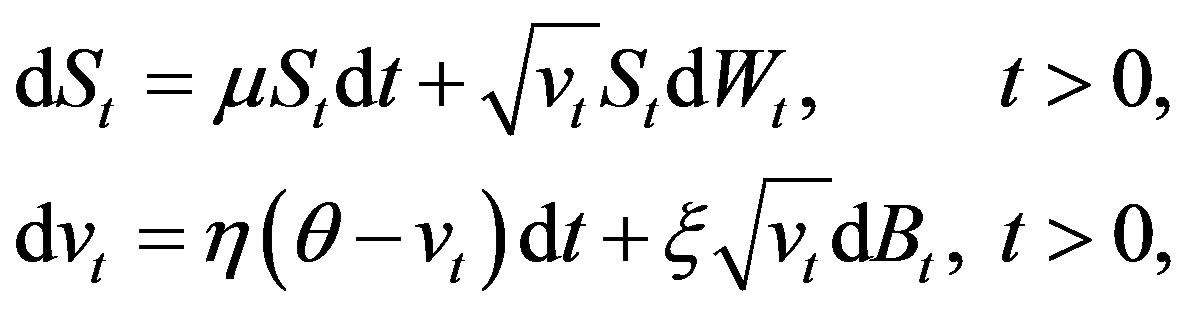

In [3]:
# S
observed_prices = yf.download(STOCK_NAME, period=TIME_PERIOD, interval=TIME_INTERVAL)["Adj Close"]
# t
observation_times = observed_prices.index.astype("int64")  # datetime to number of 1e-9 seconds since 1/1/1970
observation_times = (observation_times - min(observation_times)) / 1e9

[*********************100%***********************]  1 of 1 completed


In [4]:
# ν
time_deltas = pd.Series(observation_times.diff(), index=observed_prices.index)
price_quotients = observed_prices.diff() / observed_prices
local_volatilities = price_quotients.rolling(LOCAL_WINDOW_SIZE).var().div(time_deltas).shift(periods=LOCAL_WINDOW_SIZE)

In [5]:
# the observed process as a whole
observed_heston_process = pd.DataFrame({
    "S": observed_prices,
    "t": observation_times,
    "ν": local_volatilities,
    }, index=observed_prices.index
).dropna()

/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_5748/2085753594.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _times = torch.tensor(observed_heston_process["t"], requires_grad=False)


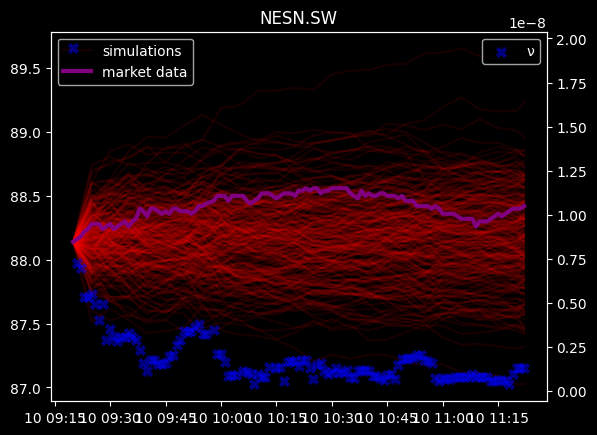

In [6]:
# verification

class VerificationHeston(torch.nn.Module):

    noise_type = "diagonal"
    sde_type = "ito"
    state_size = 1
    brownian_size = 1

    def __init__(self, local_volatilities, index):
        super().__init__()
        self.local_volatilities = local_volatilities
        self.index = index

    def f(self, t, y):
        return 0 * y

    def g(self, t, y):
        closest_index = torch.argmin(torch.abs(self.index - t))
        volatility = self.local_volatilities[closest_index]
        return torch.sqrt(volatility) * y

_times = torch.tensor(observed_heston_process["t"], requires_grad=False)
_s0 = torch.tensor(observed_heston_process["S"].iloc[0], requires_grad=False).repeat(256, 1)
_local_volatilities = torch.tensor(list(observed_heston_process["ν"]), requires_grad=False)
_sde = VerificationHeston(_local_volatilities, _times)

_solution = torchsde.sdeint(_sde, _s0, _times, method="euler", dt=DT)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i, trajectory in enumerate(_solution.transpose(0, 1).squeeze()):
    ax1.plot(observed_heston_process.index, trajectory, c="red", alpha=.1, label="simulations" if i == 0 else None)
ax1.plot(observed_heston_process.index, list(observed_heston_process["S"]), c="purple", linewidth=3, label="market data")
ax1.legend()
ax2.scatter(observed_heston_process.index, list(observed_heston_process["ν"]), c="blue", linewidth=3, alpha=.5, label="ν", marker="x")
ax2.legend()
plt.title(STOCK_NAME)
plt.show()